In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import collections

In [ ]:
nx.DiGraph().number_of_nodes

In [ ]:
# Remove streets without cars going through

In [186]:
class Submission:
    def __init__(self, dataset):
        self.dataset = dataset

        # schedule for each intersection: each second: one street name
        self.intersections = collections.defaultdict(list)

    def is_green(self, street_name, time):
        intersection = self.dataset.street_to_intersections[street_name][1]
        schedule = self.intersections[intersection]
        if not schedule:
            return False
        time = time % len(schedule)
        return schedule[time] == street_name

    def write(self, output_path):
        with open(output_path, 'w') as f:
            f.write("%d\n" % len(self.intersections))
            for inter in self.intersections:
                f.write("%d\n" % inter)
                sched = collections.Counter(self.intersections[inter])
                N_streets = len(sched)
                f.write("%d\n" % N_streets)
                for name, duration in sched.items():
                    f.write("%s %d\n" % (name, duration))
                    
    def auto_no_predecsessors(self):
        for n in self.dataset.graph:
            preds = list(self.dataset.graph.predecessors(n))
            if len(preds) == 1:
                # This intersection has only one street going: we set it to always green
                street = self.dataset.graph[preds[0]][n]['street']
                self.intersections[n] = [street]
                
                
    def auto_alternate(self):
        for n in self.dataset.graph:
            preds = list(self.dataset.graph.predecessors(n))
            if len(preds) > 1:
                streets = [self.dataset.graph[p][n]['street'] for p in preds]
                self.intersections[n] = streets
                    
                    
    def load_file(self, file_path):
        self.intersections = collections.defaultdict(list)
        with open(file_path, 'r') as f:
            A = int(f.readline())
            for _ in range(A):
                inter_id = int(f.readline())
                ei = int(f.readline())
                for i in range(ei):
                    street_name, duration = f.readline().split()
                    duration = int(duration)
                    self.intersections[inter_id] += [street_name] * duration
                
            



class Dataset:
    @staticmethod
    def from_file(file_name):
        with open(file_name) as f:
            D, I, S, V, F = map(int, f.readline().split())
            streets = []
            for _ in range(S):
                b, e, street_name, L = f.readline().split()
                b = int(b)
                e = int(e)
                L = int(L)
                streets.append((b, e, L, street_name))

            cars = []
            for _ in range(V):
                P, *st = f.readline().split()
                P = int(P)
                assert P == len(st)
                cars.append(st)

        dataset = Dataset(D, I, S, V, F, streets, cars)
        dataset.file_name = file_name
        return dataset

    def __init__(self, D, I, S, V, F, streets, cars):
        self.duration_simulation = D
        self.n_intersections = I  # Number of nodes in graph
        self.n_streets = S
        self.n_cars = V
        self.bonus_unit = F
        self.graph = nx.DiGraph()

        self.street_to_intersections = dict()
        for b, e, L, street_name in streets:
            self.street_to_intersections[street_name] = (b, e, L)
            self.graph.add_edge(b, e, duration=L, street=street_name)

        self.cars = cars

        assert self.graph.number_of_nodes() == self.n_intersections

    def summary_instance(self):
        print("Duration: %d s  and #Cars: %d" % (self.duration_simulation, self.n_cars))
        print(
            "#Intersections: %d ; #Streets: %d" % (self.n_intersections, self.n_streets)
        )
        print("Bonus per car: %d" % self.bonus_unit)
        print(
            "Number connected components "
            + str(nx.number_connected_components(self.graph.to_undirected()))
        )

        path_data = [len(streets) for streets in self.cars]
        plt.hist(path_data)
        plt.title("Path lengths")
        plt.show()

        path_data = [
            sum([self.street_to_intersections[s][2] for s in streets[1:]])
            for streets in self.cars
        ]
        plt.hist(path_data)
        plt.title("Path durations")
        plt.show()

        n_street = collections.defaultdict(int)
        for c in self.cars:
            for s in c[1]:
                n_street[s] += 1

    def save_graph(self):
        nx.write_graphml(self.graph, self.file_name + ".graphml")

    @property
    def D(self):
        return self.duration_simulation


class Simulation:
    def __init__(self, schedule):
        self.schedule = schedule

        self.streets = collections.defaultdict(list)
        for street_name in schedule.dataset.street_to_intersections:
            self.streets[street_name] = []
        
        for i, car in enumerate(schedule.dataset.cars):
            self.streets[car[0]].append((0, (i, 0)))

    def simulate(self, log=False):
        score = 0
        for t in range(self.schedule.dataset.duration_simulation):
            # Pop 1 car per max street
            for street_name in self.streets:
                if not self.streets[street_name]:
                    continue
                car = self.streets[street_name][0]
                if car[0] > t:
                    # The car has not arrived yet
                    continue
                # Car is here: if green, it goes
                if self.schedule.is_green(street_name, t):
                    car_t, (car_id, car_state) = self.streets[street_name].pop(0)
                    if car_state == len(self.schedule.dataset.cars[car_id]) - 1:
                        # Add SCORE HERE
                        cur_score = self.schedule.dataset.bonus_unit + (self.schedule.dataset.duration_simulation - t)
                        if log:
                            print("Car %d arrived")
                        score += cur_score
                    else:
                        # move car to next street
                        next_street = self.schedule.dataset.cars[car_id][car_state + 1]
                        
                        self.streets[next_street].append(
                            (
                                t
                                + self.schedule.dataset.street_to_intersections[street_name][2],
                                (car_id, car_state+1)
                            )
                        )
                        #self.streets[next_street].sort(key=lambda x: x[0])
                        
                        
        print(score)

In [187]:
data_a = Dataset.from_file('data/a.txt')

In [188]:
submission = Submission(data_a)
submission.load_file('solutionA.txt')

In [189]:
sim = Simulation(submission)

In [190]:
sim.simulate()

1002


In [121]:
submission.intersections

defaultdict(list,
            {1: ['rue-d-athenes', 'rue-d-athenes', 'rue-d-amsterdam'],
             0: ['rue-de-londres', 'rue-de-londres'],
             2: ['rue-de-moscou']})

In [120]:
data_a.street_to_intersections

{'rue-de-londres': (2, 0, 1),
 'rue-d-amsterdam': (0, 1, 1),
 'rue-d-athenes': (3, 1, 1),
 'rue-de-rome': (2, 3, 2),
 'rue-de-moscou': (1, 2, 3)}

In [109]:
submission.intersections

defaultdict(list, {3: []})

Duration: 5070 s  and #Cars: 1000
#Intersections: 7073 ; #Streets: 9102
Bonus per car: 1000
Number connected components 11


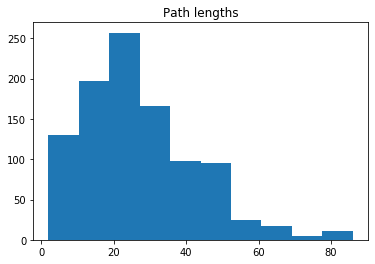

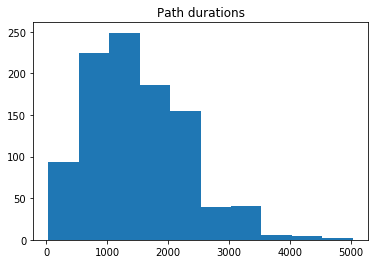

In [47]:
data_b = Dataset.from_file('data/b.txt')
data_b.summary_instance()

Duration: 676 s  and #Cars: 1000
#Intersections: 500 ; #Streets: 998
Bonus per car: 500
Number connected components 1


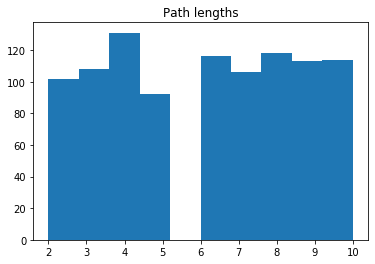

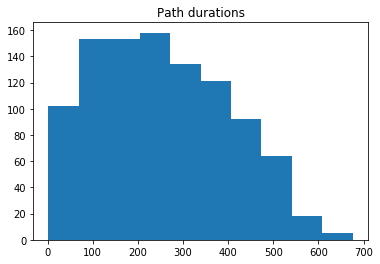

In [149]:
data_e = Dataset.from_file('data/e.txt')
data_e.summary_instance()

In [178]:
submission_e = Submission(data_e)
submission_e.auto_no_predecsessors()
submission_e.auto_alternate()
submission_e.intersections

defaultdict(list,
            {0: ['eji-a'],
             2: ['b-c'],
             4: ['d-e'],
             6: ['f-g'],
             8: ['h-i'],
             10: ['j-ba'],
             12: ['bb-bc'],
             14: ['bd-be'],
             16: ['bf-bg'],
             18: ['bh-bi'],
             20: ['bj-ca'],
             22: ['cb-cc'],
             24: ['cd-ce'],
             26: ['cf-cg'],
             28: ['ch-ci'],
             30: ['cj-da'],
             32: ['db-dc'],
             34: ['dd-de'],
             36: ['df-dg'],
             38: ['dh-di'],
             40: ['dj-ea'],
             42: ['eb-ec'],
             44: ['ed-ee'],
             46: ['ef-eg'],
             48: ['eh-ei'],
             50: ['ej-fa'],
             52: ['fb-fc'],
             54: ['fd-fe'],
             56: ['ff-fg'],
             58: ['fh-fi'],
             60: ['fj-ga'],
             62: ['gb-gc'],
             64: ['gd-ge'],
             66: ['gf-gg'],
             68: ['gh-gi'],
             70:

In [180]:
submission_e.write('sub-e.txt')

In [179]:
sim_e = Simulation(submission_e)
sim_e

627873


In [158]:
list(data_e.graph.predecessors(0))

[498]

In [151]:
list(data_e.graph.predecessors(499))

[0,
 2,
 4,
 6,
 8,
 10,
 12,
 14,
 16,
 18,
 20,
 22,
 24,
 26,
 28,
 30,
 32,
 34,
 36,
 38,
 40,
 42,
 44,
 46,
 48,
 50,
 52,
 54,
 56,
 58,
 60,
 62,
 64,
 66,
 68,
 70,
 72,
 74,
 76,
 78,
 80,
 82,
 84,
 86,
 88,
 90,
 92,
 94,
 96,
 98,
 100,
 102,
 104,
 106,
 108,
 110,
 112,
 114,
 116,
 118,
 120,
 122,
 124,
 126,
 128,
 130,
 132,
 134,
 136,
 138,
 140,
 142,
 144,
 146,
 148,
 150,
 152,
 154,
 156,
 158,
 160,
 162,
 164,
 166,
 168,
 170,
 172,
 174,
 176,
 178,
 180,
 182,
 184,
 186,
 188,
 190,
 192,
 194,
 196,
 198,
 200,
 202,
 204,
 206,
 208,
 210,
 212,
 214,
 216,
 218,
 220,
 222,
 224,
 226,
 228,
 230,
 232,
 234,
 236,
 238,
 240,
 242,
 244,
 246,
 248,
 250,
 252,
 254,
 256,
 258,
 260,
 262,
 264,
 266,
 268,
 270,
 272,
 274,
 276,
 278,
 280,
 282,
 284,
 286,
 288,
 290,
 292,
 294,
 296,
 298,
 300,
 302,
 304,
 306,
 308,
 310,
 312,
 314,
 316,
 318,
 320,
 322,
 324,
 326,
 328,
 330,
 332,
 334,
 336,
 338,
 340,
 342,
 344,
 346,
 348,
 350,

Text(0.5, 1.0, 'duration of streets going out 499')

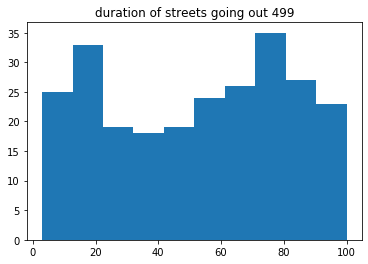

In [80]:
plt.hist([data_e.graph[499][k]['duration'] for k in data_e.graph[499]])
plt.title("duration of streets going out 499")

In [81]:
## All cars are going through 499 once

In [70]:
for street in data_b.cars[7][1]:
    print(data_b.street_to_intersections[street])

(487, 488, 70)
(488, 499, 57)
(499, 365, 89)
(365, 366, 44)
(366, 367, 17)
(367, 368, 100)
(368, 369, 10)


In [76]:
tmp = []
for c in data_e.cars:
    tmp.append(data_b.street_to_intersections[c[1][0]][1])

In [ ]:
Noeuds pairs verts
Noeuds 

Duration: 5070 s  and #Cars: 1000
#Intersections: 7073 ; #Streets: 9102
Bonus per car: 1000
Number connected components 11


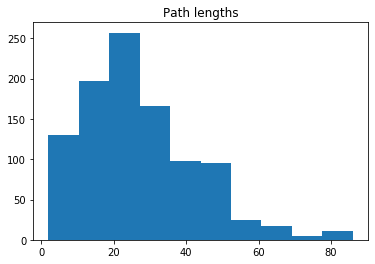

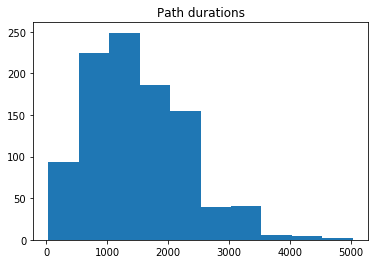

Duration: 1640 s  and #Cars: 1000
#Intersections: 10000 ; #Streets: 35030
Bonus per car: 100
Number connected components 1


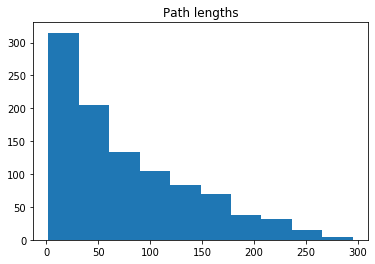

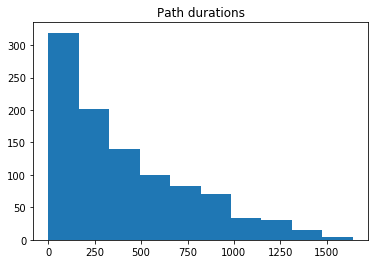

Duration: 8071 s  and #Cars: 1000
#Intersections: 8000 ; #Streets: 95928
Bonus per car: 1000
Number connected components 1


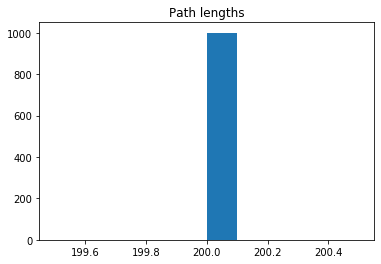

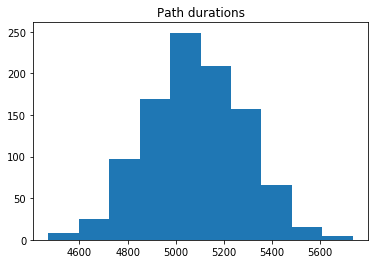

Duration: 676 s  and #Cars: 1000
#Intersections: 500 ; #Streets: 998
Bonus per car: 500
Number connected components 1


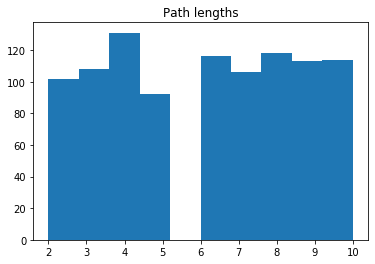

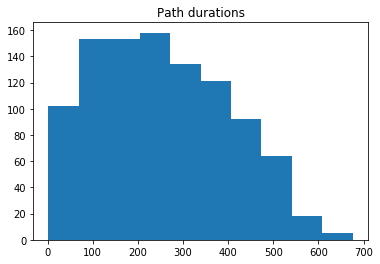

Duration: 1992 s  and #Cars: 1000
#Intersections: 1662 ; #Streets: 10000
Bonus per car: 500
Number connected components 1


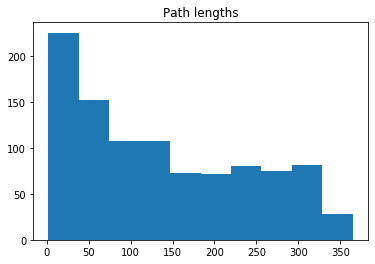

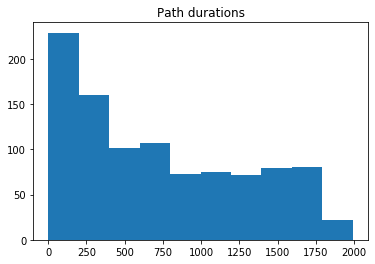

In [86]:
for d in ['data/b.txt','data/c.txt','data/d.txt','data/e.txt','data/f.txt',]:
    e = Dataset.from_file(d)
    e.summary_instance()
    e.save_graph()

In [94]:
for d in ['data/b.txt','data/c.txt','data/d.txt','data/e.txt','data/f.txt',]:
    e = Dataset.from_file(d)
    print(d, nx.bipartite.is_bipartite(e.graph))

data/b.txt False
data/c.txt True
data/d.txt False
data/e.txt False
data/f.txt False
